<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: Calwebb_coron3 for MIRI coronagraphic imaging
<span style="color:red"> **Instruments Affected**</span>: MIRI, NIRCam 

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#test_descr)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Load Input Data](#data_load)
<br> [Run the Pipeline](#run_pipeline)
<br> [Examine Outputs](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for stage 3 coronagraphic processing of MIRI 4QPM exposures. The stage 3 coronagraphic pipeline ([`calwebb_coron3`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html#calwebb-coron3)) is to be applied to associations of calibrated NIRCam and MIRI coronagraphic exposures, and is used to produce PSF-subtracted, resampled, combined images of the source object. For more information on `calwebb_coron3`, please visit the links below.

> Module description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html#calwebb-coron3

> Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/coron/


[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm


The algorithms for `CALWEBB_CORON3` are as follows:

- **Assemble Reference PSFs**: <br>
All the available reference PSFs are assembled into the appropriate association.


- **Outlier detection**: <br> 
An iterative sigma clipping algorithm is used in pixel coordinates on the image stack. The presence of an outlier results in a pixel flag being set. Examine the stack of exposures in detector coordinates and identify outliers.


- **Align reference PSFs**: <br>
The reference PSFs are aligned with the target observation using the Fourier LSQ algorithm to measure the shifts and the Fourier Shift algorithm to apply the shifts to each reference PSF integration.


- **Reference PSF subtraction**: <br>
The reference PSF that is subtracted from each target integration is created using the list of reference PSFs and the KLIP algorithm. 


- **Image Combination**: <br>
The target images (including those at different rotations) are combined into a single combined image using the AstroDrizzle code (with the output pixel size set to the input pixel size).


- **Updated Exposure Level Products**: <br>
The exposure level products are re-created to provide the highest quality products that include the results of the ensemble processing (updated WCS, matching backgrounds, and 2nd pass outlier detection). 

<BR>

The current status of these algorithms are summarized in the link below:

> https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html#calwebb-coron3


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

- **JWST**: James Webb Space Telescope ([see documentation](https://jwst-docs.stsci.edu/))
- **MIRI**: Mid-Infrared Instrument ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument))
- **NIRCam**: Near-Infrared Instrument ([see documentation](https://jwst-docs.stsci.edu/near-infrared-camera))
- **4QPM**: 4 Quadrant Phase Mask ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-4qpm))
- **Lyot**: coronagraph design incorporating a classical Lyot spot ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-lyotcoron))
- **PanCAKE**: an in-house tool at STScI used to simulate coronagraphic PSFs 
([see documentation](https://github.com/spacetelescope/pandeia-coronagraphy))
- **SGD**: Small Grid Dither 
([see documentation](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/hci-proposal-planning/hci-small-grid-dithers))
- **RSCD**: Reset-Switch Charge Decay ([see documentation](https://jwst-pipeline.readthedocs.io/en/stable/jwst/rscd/description.html))
    
    

    
 [Top of Page](#title_ID)

<a id="test_descr"></a>
# Test Description

This notebook tests the the following steps applied by `calwebb_coron3` for pipeline version == **'0.17.1'**.
 - [**outlier_detection**](#outlier_detection)
 - [**stack_refs**](#stack_refs)
 - [**align_refs**](#align-refs)
 - [**klip**](#klip)
 - [**resample**](#resample)

These tests are performed using MIRI F1550C 4QPM coronagraphic data (see [Data Description](#data_descr)).


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

### Input Data:

This notebook uses MIRI 1140C 4QPM coronagraphic observtions of the young debris disk around HD 141569A obtained from JWST ERS program #[1386](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1386): High Contrast Imaging of Exoplanets and Exoplanetary Systems with JWST. 

The data consists of two science exposures and five reference PSF exposures based on the following observation scenario (1) two science observations of the disk HD 141569A performerd at seperate roll angles in order to obtain 360 azimuthan coverage of the disk (2) the execution of a 5-point small grid dither (SGD) pattern on the PSF reference star u Cen, to obtain a set of five slightly offset reference PSF observations.

The data has the following naming format:

* **Science exposures**: 
    - 'jw01386022001_04101_00001_mirimage_calints.fits' (HD 141569 - *Roll 1*)
    - 'jw01386023001_04101_00001_mirimage_calints.fits' (HD 141569 - *Roll 2*)<br></br>
    
* **PSF Reference expsores**:
    - `jw01386024001_04101_00001_mirimage_calints.fits` (HD 140986 - *position 1/5 in SGD pattern*)
    - `jw01386024001_04101_00002_mirimage_calints.fits` (HD 140986 - *position 2/5 in SGD pattern*)
    - `jw01386024001_04101_00003_mirimage_calints.fits` (HD 140986 - *position 3/5 in SGD pattern*)
    - `jw01386024001_04101_00004_mirimage_calints.fits` (HD 140986 - *position 4/5 in SGD pattern*)
    - `jw01386024001_04101_00005_mirimage_calints.fits` (HD 140986 - *position 5/5 in SGD pattern*)

The ERS data used in this tutorial can be downloaded directly from MAST (mast.stsci.edu). The following link provides a shortcut: [1386 MAST data download](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMBYPROPID%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22proposal_id%22%2C%22niceName%22%3A%22proposal_id%22%2C%22values%22%3A%5B%221386%22%5D%2C%22valString%22%3A%221386%22%2C%22displayString%22%3A%221386%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22discrete%22%7D%5D%2C%22paramsService%22%3A%22Mast.Caom.Filtered%22%2C%22title%22%3A%22Proposal%20ID%20Results%22%2C%22columns%22%3A%22*%22%2C%22caomVersion%22%3Anull%7D).


### Refence Files:

The `align_refs` step requires a PSFMASK reference file containing a 2D mask that’s used as a weight function when computing shifts between images. 

> File description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/description.html#psfmask-reffile
 

### Association File:

Currently the individual stage 3 coronagraphic processing steps can only be run in a convenient way by running the `calwebb_coron3` pipeline on an association (ASN) file that lists the various science target and reference PSF exposures to be processed. 

> Level 3 Associations documentation: https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_rules.html


[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports
* `jwst` is the main package for the James Webb Space Telescope (JWST) pipeline.
* `jwst.Coron3Pipeline` is the specific pipeline within the `jwst.pipeline` package used to reduce JWST coronagraphic imaging data.

* `os` to interact with the operating system.
* `glob` to search for files.
* `tempfile.TemporaryDirectory` to create a temporary directory for testing.
* `numpy` for array calculations and manipulation.
* `matplotlib.pyplot` for visualizing data.
* `mpl_toolkits.axes_grid1` provides a way to create axes with adjustable size and position.
* `astropy.io.fits` for working with FITS files.
* `ci_watson.artifactory_helpers.get_bigdata` for downloading the data files from from the Artifactory server.
* `pysiaf.Siaf` for accessing the JWST Science Instrument Aperture Files (SIAFs).
* `jwst.pipeline.Coron3Pipeline` provides a way to run the JWST Coronagraphic Science pipeline.
[Top of Page](#title_ID)

In [1]:
# Import necessary modules
import os
import glob
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits
from astropy.utils.data import download_file

from ci_watson.artifactory_helpers import get_bigdata

from pysiaf import Siaf

import jwst
from jwst.pipeline import Coron3Pipeline

# Set up notebook for inline plotting and configure inline figures to remain open
%matplotlib inline
%config InlineBackend.close_figures=False

# Set up the CRDS_PATH environment accordingly
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS (Calibration Reference Data System) cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS (Calibration Reference Data System) cache location: /grp/crds/cache


In [2]:
jwst.__version__
# should out '1.9.5'

'1.9.5'

<a id="data_load"></a>
# Load Input Data

In [3]:
import shutil
# Create temporary directory
data_dir = TemporaryDirectory()
print(f"Created temporary directory: {data_dir}")

# Copy all files in subdirectory to temporary directory
sub_dir = "1386_data"
for file_name in os.listdir(sub_dir):
    if os.path.isfile(os.path.join(sub_dir, file_name)):
        shutil.copy(os.path.join(sub_dir, file_name), os.path.join(data_dir.name, file_name))
        #print(f"Copied {os.path.join(sub_dir, file_name)} to {data_dir}")

# Change to temporary directory
os.chdir(data_dir.name)
print(f"Changed to temporary directory: {os.getcwd()}")

Created temporary directory: <TemporaryDirectory '/var/folders/l2/wgr6462s4ng8ssmkhk3vcdv80001jx/T/tmp5gqzqwm7'>
Changed to temporary directory: /private/var/folders/l2/wgr6462s4ng8ssmkhk3vcdv80001jx/T/tmp5gqzqwm7


## Generate an association file

For running the Level 3 pipeline, you have need an association file to tell the pipeline which exposures belong to the reference star and which to the science star. There are two ways to do this:

 - Downloading the association files (ASN, in MAST), find the association file you want and replace the filenames with the filenames of the background-subtracted version.
Write your own dummy file, which is what we will do here.


In [4]:
data_files =  sorted(glob.glob("j*calints.fits"))

In [5]:
# Create an empty dictionary to store the files
file_dict = {'science': [], 'psf': []} 

# sort the files
for file in data_files:
    # Open the FITS file and get the value of the 'TARGNAME' header keyword
    with fits.open(file) as hdul:
        targname = hdul[0].header.get('TARGNAME')
    if targname == 'HD 141569':
        file_dict['science'].append(str(file))
    elif targname == 'HD 140986':
        file_dict['psf'].append(str(file))

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
def write_dummy_asn(filename, name, filedict):
    """
    Write a dummy ASN file for manually processing files through Level 3

    Parameters
    ----------
    filedict: dict
      dict where the key is the relative path and filename for the association
      file, and the value is "science" or "psf"
    name: prefix for the stage 3 output files
    sci_files: list of str
      list of paths to the science image files
    psf_files: list of str
      list of paths to the psf image files

    Output
    ------
    association file written to given location

    """
    # make the specifications for the image files
    def make_entries(filedict, ntabs=3):
        tab='\t'
        line = lambda key, val: f"\"expname\": \"{key}\",\n\"exptype\": \"{val}\""
        lines = f"\n}},{{\n".join(line(key, val) for key, val in filedict.items())
        return lines
    file_str = make_entries(filedict, 5)

    template = f"""{{
    "asn_type": "coron3",
    "asn_rule": "candidate_Asn_Lv3Coron",
    "program": "{name}",
    "asn_id": "c1001",
    "target": "dummy",
    "asn_pool": "{name}-pool",
    "products": [{{
        "name": "{name}",
        "members": [{{
                    {file_str}
    }}]
    }}]
    }}"""
    # make sure the file ends in .json
    filename = Path(filename).with_suffix(".json")
    with open(str(filename), 'w') as ff:
        ff.write(template)

In [31]:
write_dummy_asn(asn_filename, "01386_hd141569a_1550", file_dict)

[Top of Page](#title_ID)
<a id="run_pipeline"></a>


------------

# Run the Pipeline

In [54]:
asn_dir = 'jw01386-c1027_coron3_00001_asn.json' # Define ASN file
myCoron3Pipeline = Coron3Pipeline()                              
myCoron3Pipeline.save_results = True 
myCoron3Pipeline.klip.truncate = 5 # it's a disk target so we don't want to use many KLIP modes. Default is 50
myCoron3Pipeline.output_dir = os.getcwd() 
myCoron3Pipeline.run(asn_dir) # run pipeline

2023-03-27 17:01:48,708 - stpipe.Coron3Pipeline - INFO - Coron3Pipeline instance created.
2023-03-27 17:01:48,710 - stpipe.Coron3Pipeline.stack_refs - INFO - StackRefsStep instance created.
2023-03-27 17:01:48,712 - stpipe.Coron3Pipeline.align_refs - INFO - AlignRefsStep instance created.
2023-03-27 17:01:48,713 - stpipe.Coron3Pipeline.klip - INFO - KlipStep instance created.
2023-03-27 17:01:48,716 - stpipe.Coron3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-03-27 17:01:48,718 - stpipe.Coron3Pipeline.resample - INFO - ResampleStep instance created.
2023-03-27 17:01:50,299 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline running with args ('jw01386-c1027_coron3_00001_asn.json',).
2023-03-27 17:01:50,302 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/private/var/folders/l2/wgr6462s4ng8ssmkhk3vcdv80001jx/T/tmply0jk4fj', 'output_ext': '.fits', 'output_use_mo

2023-03-27 17:01:54,541 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 18 (0.03%)
2023-03-27 17:01:54,550 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 1 (0.00%)
2023-03-27 17:01:54,560 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 1 (0.00%)
2023-03-27 17:01:54,569 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 3 (0.00%)
2023-03-27 17:01:54,736 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in /private/var/folders/l2/wgr6462s4ng8ssmkhk3vcdv80001jx/T/tmply0jk4fj/jw01386024001_04101_00001_mirimage_c1027_crfints.fits
2023-03-27 17:01:54,737 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done
2023-03-27 17:01:56,041 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(4, 224, 288) from jw01386024001_04101_00002_mirimage_calints.fits>,).
2023-03-27 17:01:

2023-03-27 17:02:01,818 - stpipe.Coron3Pipeline.outlier_detection - INFO - Performing outlier detection with 4 inputs
2023-03-27 17:02:01,850 - stpipe.Coron3Pipeline.outlier_detection - WARNING - /Users/bnickson/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample_utils.py:184: RuntimeWarning: var_rnoise array not available. Setting drizzle weight map to 1
  warnings.warn("var_rnoise array not available. Setting drizzle weight map to 1",

2023-03-27 17:02:02,222 - stpipe.Coron3Pipeline.outlier_detection - INFO - Flagging outliers
2023-03-27 17:02:02,231 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 11 (0.02%)
2023-03-27 17:02:02,240 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 2 (0.00%)
2023-03-27 17:02:02,249 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 3 (0.00%)
2023-03-27 17:02:02,259 - stpipe.Coron3Pipeline.outlier_detection - INFO

2023-03-27 17:02:50,215 - stpipe.Coron3Pipeline.outlier_detection - INFO - Performing outlier detection with 6 inputs
2023-03-27 17:02:50,247 - stpipe.Coron3Pipeline.outlier_detection - WARNING - /Users/bnickson/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample_utils.py:184: RuntimeWarning: var_rnoise array not available. Setting drizzle weight map to 1
  warnings.warn("var_rnoise array not available. Setting drizzle weight map to 1",

2023-03-27 17:02:50,716 - stpipe.Coron3Pipeline.outlier_detection - INFO - Flagging outliers
2023-03-27 17:02:50,725 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 13 (0.02%)
2023-03-27 17:02:50,734 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 41 (0.06%)
2023-03-27 17:02:50,744 - stpipe.Coron3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 8 (0.01%)
2023-03-27 17:02:50,754 - stpipe.Coron3Pipeline.outlier_detection - INF

2023-03-27 17:03:33,682 - stpipe.Coron3Pipeline.resample - INFO - Resampling var_poisson
2023-03-27 17:03:33,706 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,735 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,772 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,805 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,834 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,864 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,894 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,934 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270, 321)
2023-03-27 17:03:33,965 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (270

[Top of Page](#title_ID)
<a id="testing"></a>
--------------
# Examine Output Data 

First we define some plotting helper functions that will overlay the SIAF aperture boundaries and reference point on the data

In [7]:
# First, here are some plotting utitlies to overlay SIAF information about the subarray
# over the images
miri_siaf = Siaf("MIRI")
aper_name = f'MIRIM_{fits.getval(data_files[0], "SUBARRAY", 0)}'

def plot_with_aper(img, aper_name=aper_name, ax=None, fig_kws={}, plot_kws={}, cbar_kws={}):
    """
    Plots an image with a specified aperture and reference point overlaid on top.

    Parameters
    ----------
    img : numpy.ndarray
        The 2D image data to be plotted.
    aper_name : str, optional
        The SIAF-searchable name of the aperture to be overlaid.
    ax : matplotlib.axes.Axes, optional
        The matplotlib axis object to use for plotting. If not provided, a new axis is created.
    fig_kws : dict, optional
        Additional keyword arguments to pass to the `plt.subplots` function when creating a new axis.
    plot_kws : dict, optional
        Additional keyword arguments to pass to the `ax.pcolor` function when plotting the image 
        (e.g. ax.imshow(img, **plot_kws)).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object.
    ax : matplotlib.axes.Axes
        The matplotlib axis object used for plotting.
    """
    if ax == None:
        fig, ax = plt.subplots(1, 1, **fig_kws)
    else:
        fig = ax.get_figure()
    ax.set_xlabel("subarray pixel")
    ax.set_ylabel("subarray pixel")

    aper = Siaf("MIRI")[aper_name]
    aper.plot(frame='sci', ax=ax, fill=False, mark_ref=True, c='C1')

    # using the aperture corner definitions to set the plot coordinates
    # ensures that the plotted image will match up with the aperture's 
    # features, e.g. the reference point
    corners = aper.corners('sci')
    x, y = np.meshgrid(np.arange(corners[0].min(), corners[0].max()+1, 1),
                       np.arange(corners[1].min(), corners[1].max()+1, 1))
    
    im = ax.pcolor(x, y, img, zorder=-1, **plot_kws)
    
    lolim, hilim = np.min(corners, axis=1), np.max(corners, axis=1)
    ax.set_xlim(lolim[0]-5, hilim[0]+5)
    ax.set_ylim(lolim[1]-5, hilim[1]+5)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, **cbar_kws)
    cbar.ax.tick_params(labelsize=8)
    return fig, ax

def plot_stack_with_aper(images, aper_name=aper_name, fig_kws={}, plot_kws={}):
    """
    Plots a stack of images with a specified aperture overlaid on top.

    Parameters
    ----------
    images : numpy.ndarray
        3D stack of image data to be plotted.
    aper_name : str, optional
        The SIAF-searchable name of the aperture to be overlaid. 
    fig_kws : dict, optional
        Additional keyword arguments to pass to the `plt.subplots` function when creating the figure.
    plot_kws : dict, optional
        Additional keyword arguments to pass to the `plot_with_aper` function when plotting each image.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object.
    """
    # initialize the figure
    ncols = 2
    nrows = np.ceil(images.shape[0]/ncols).astype(int)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(6*ncols, 6*nrows),
                             squeeze=False)
    for index, (ax, img) in enumerate(zip(axes.ravel(), images)):
        plot_with_aper(img, aper_name=aper_name, ax=ax, 
                       fig_kws={}, plot_kws=plot_kws);
        
    plt.tight_layout()
    return fig

<a id="stack_refs"></a>
###  `stack_refs`:  Stack PSF References (*'_psfstack' product*)

The role of the `stack_refs` step is to stack all of the PSF reference exposures (specified in the input ASN file) into a single 3D data cube for use by subsequent coronagraphic steps. The size of the stack should be equal to the sum of the number of integrations in each input PSF exposure.  The image data are simply copied and reformatted and should not be modified in any way.

*Output*: **3D PSF Image Stack** <br>
*File suffix*: **'_psfstack'**

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/stack_refs/index.html#stack-refs-step

In [33]:
stacked_cube_hdu = fits.open('jw01386-c1027_t006_miri_f1140c-mask1140_psfstack.fits')
stacked_ref_images = stacked_cube_hdu[1].data
print(stacked_cube_hdu.info())

Filename: jw01386-c1027_t006_miri_f1140c-mask1140_psfstack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     329   ()      
  1  SCI           1 ImageHDU        96   (288, 224, 20)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 20)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 20)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [8716B]   
None


In [34]:
print("'_psfstack' data product dimensions: "+str(stacked_ref_images.shape))

'_psfstack' data product dimensions: (20, 224, 288)


Plot just the stacked reference images

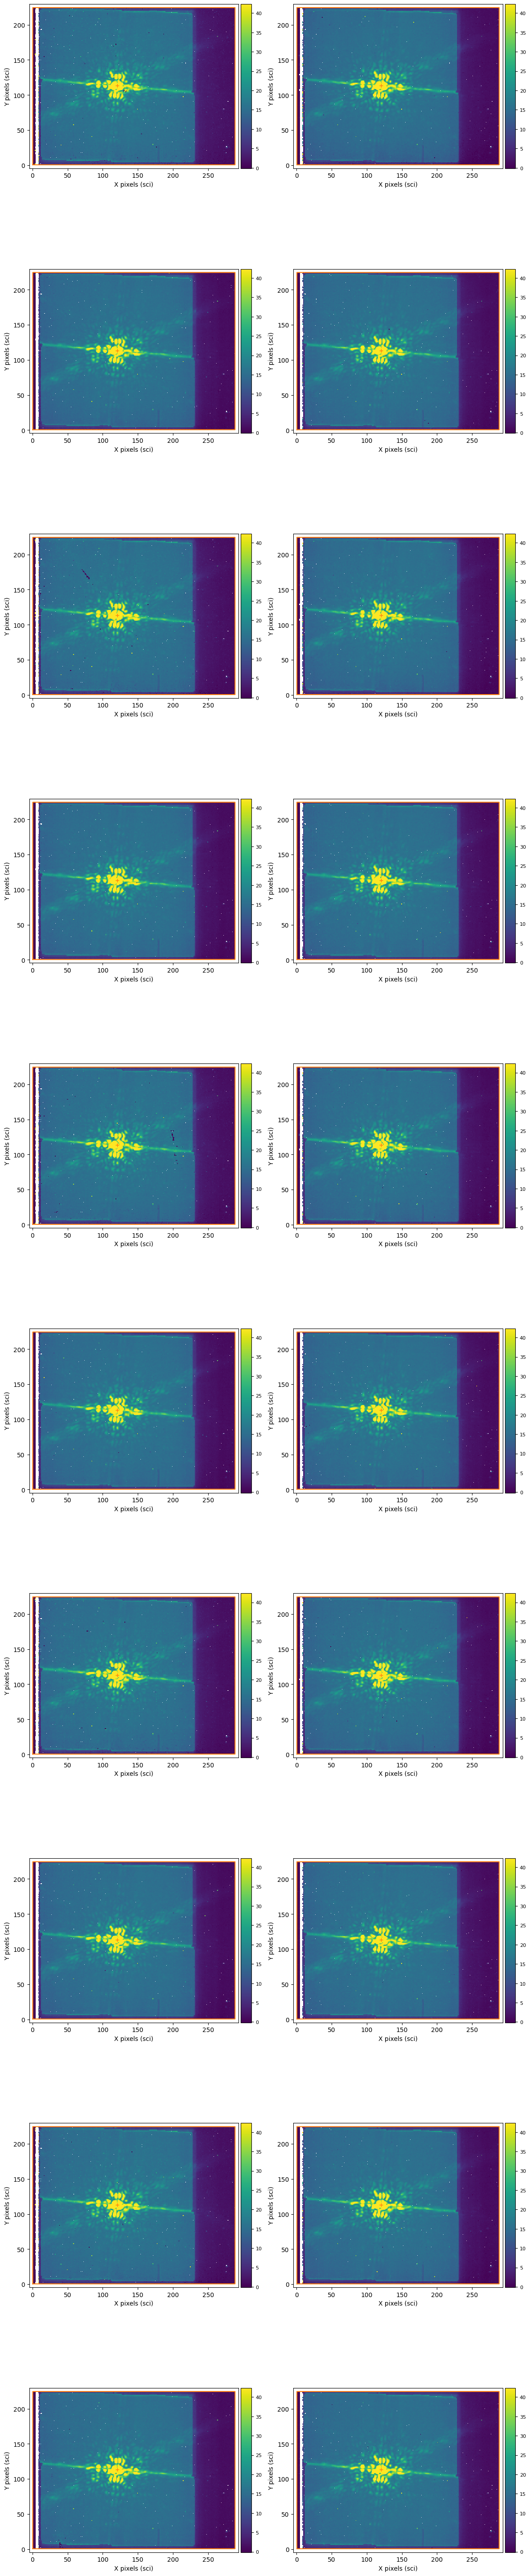

In [35]:
vmin, vmax = np.nanquantile(stacked_ref_images[0], [0.01, 0.99])
plot_kws = {'vmin':vmin, 'vmax':vmax}
fig = plot_stack_with_aper(stacked_ref_images, plot_kws=plot_kws)

The `stack_psfs` step has sucessfully stacked the reference PSF exposures into a single 3D '*_psfstack*' product, with size equal to the sum of the number of integrations in each input PSF exposure. To confirm that the image data has not been modified, the input PSF images are subtracted from each image in the stack below:

In [21]:
# Gather the input reference images
input_ref_data = np.array([fits.getdata(data_files[2]), fits.getdata(data_files[3]), fits.getdata(data_files[4]), 
                    fits.getdata(data_files[5]), fits.getdata(data_files[6])])

input_ref_images = np.concatenate((input_ref_data[0], 
                         input_ref_data[1], 
                         input_ref_data[2],
                         input_ref_data[3],
                         input_ref_data[4],), axis=0)

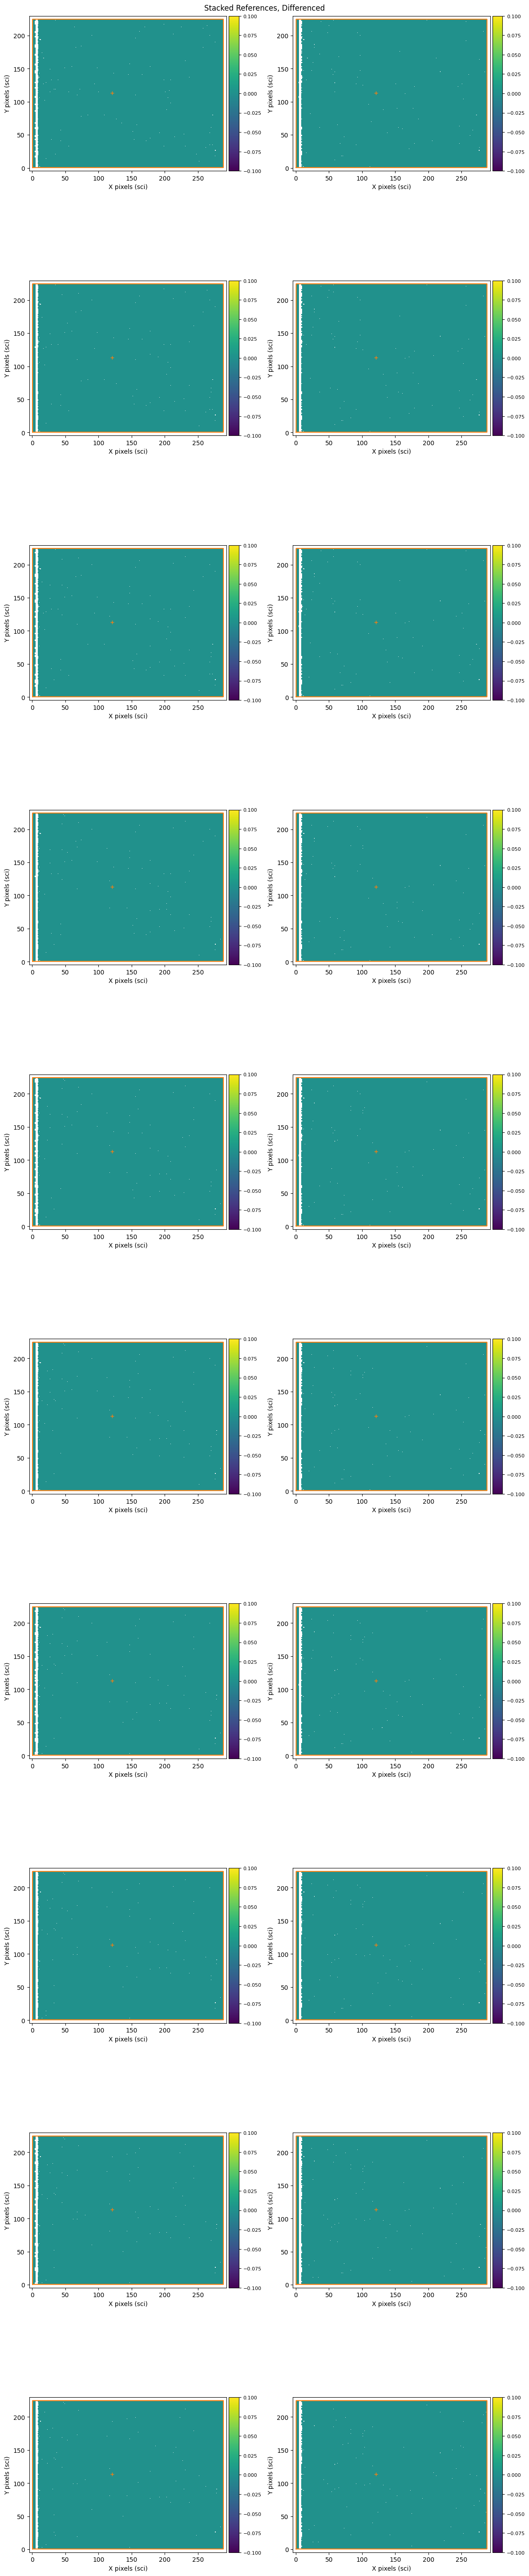

In [29]:
fig = plot_stack_with_aper(stacked_ref_images - input_ref_images)
fig.suptitle("Stacked References, Differenced");

-----------

<a id="align_refs"></a>


### `align_refs`:  Align PSF References (*'_psfalign' product*)

The role of the `align_refs` step is to align the coronagraphic PSF images with science target images. It does so by computing the offsets between the science target and reference PSF images, and shifts the PSF images into alignment. The output of the `align_refs` step is a 4D data product, where the 3rd axis has length equal to the total number of reference PSF images in the input PSF stack and the 4th axis has length equal to the number of integrations in the input science target product. 

*Output*: **4D aligned PSF Images** <br>
*File suffix*: **_psfalign**


> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/index.html#align-refs-step

In [8]:
aligned_cube_hdu = fits.open('jw01386023001_04101_00001_mirimage_c1027_psfalign.fits')
aligned_cube_hdu.info()

Filename: jw01386023001_04101_00001_mirimage_c1027_psfalign.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     334   ()      
  1  SCI           1 ImageHDU        97   (288, 224, 20, 6)   float32   
  2  ERR           1 ImageHDU        12   (288, 224, 20, 6)   float32   
  3  DQ            1 ImageHDU        13   (288, 224, 20, 6)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [8806B]   


In [9]:
aligned_cube_data = (aligned_cube_hdu[1].data)
print("'_psfalign' data product dimensions: " + str(aligned_cube_data.shape))

'_psfalign' data product dimensions: (6, 20, 224, 288)


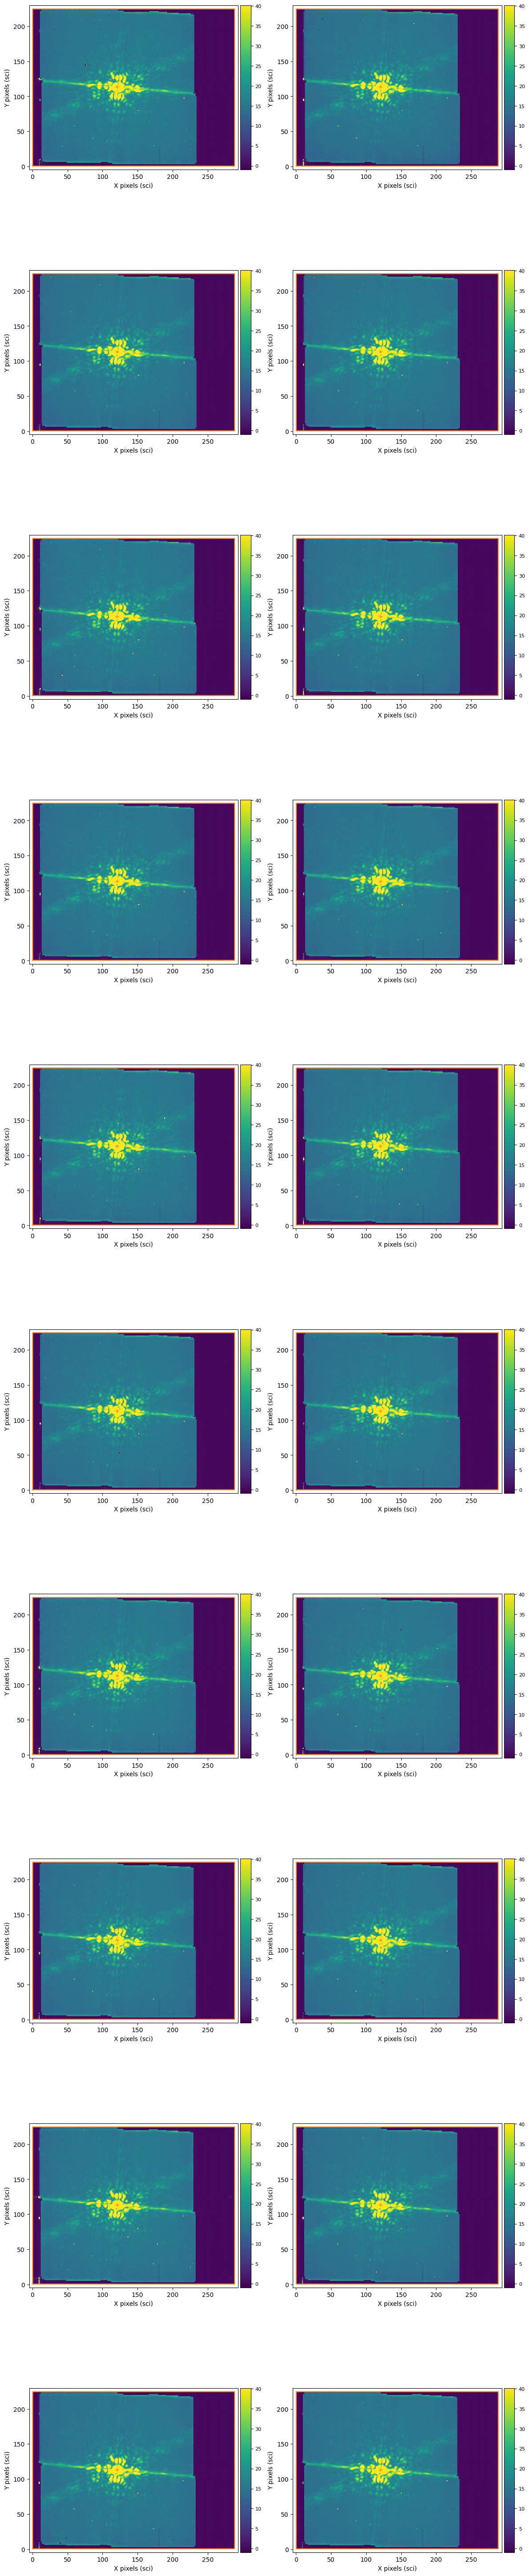

In [10]:
# cubes after alignment
aligned_images = aligned_cube_data[0]

vmin, vmax = np.nanquantile(aligned_images[0], [0.01, 0.99])
plot_kws = {'vmin':vmin, 'vmax':vmax}
fig = plot_stack_with_aper(aligned_images, plot_kws=plot_kws)
#fig.suptitle("Aligned References");

Show the stacked images, each differenced against the one before it (the first image is shown as normal)

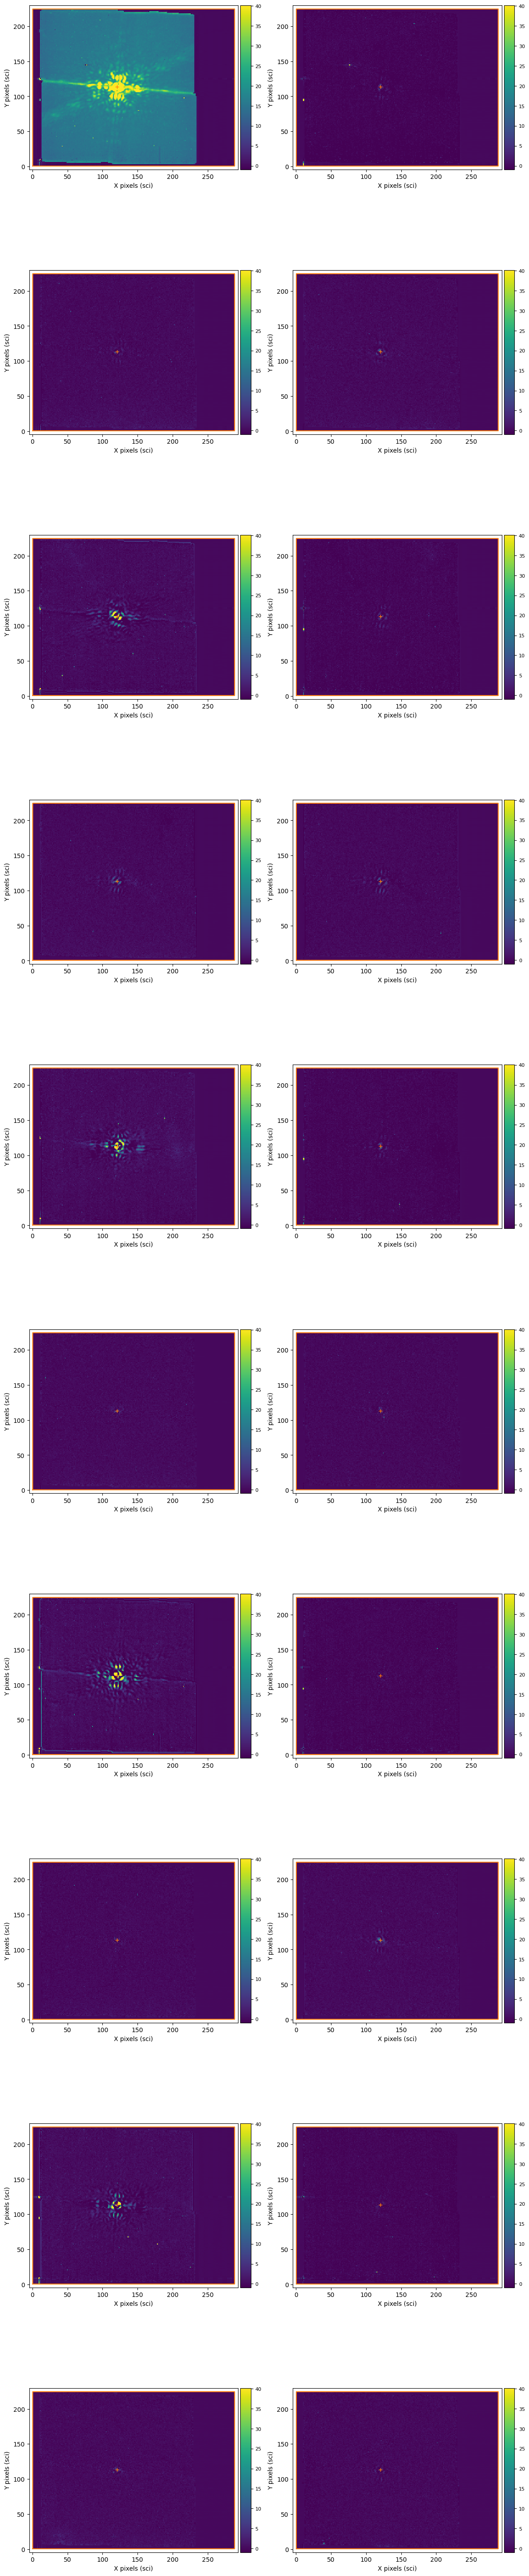

In [11]:
# subtract each aligned image from the one before it
diff_images = np.diff(aligned_cube_data[0], axis=0, prepend=0)

vmin, vmax = np.nanquantile(diff_images[0], [0.01, 0.99])
plot_kws = {'vmin':vmin, 'vmax':vmax}
fig = plot_stack_with_aper(diff_images, plot_kws=plot_kws)
#fig.suptitle("Aligned References, Differenced");

The `align_refs` step has successfully aligned the psf images - note the smaller residuals in the difference images. The first integration of each exposure is systematically different due to RSCD.

The output is indeed a 4D '*_psfalign*' product, where the 3rd axis has length equal to the total number of reference images in the input PSF stack and 4th axis equal to the number of integrations in the input science target image. 

------------
<a id="klip"></a>
### `klip`:  Reference PSF Subtraction

The role of the `klip` step is to apply the Karhunen-Loeve Image Plane (KLIP) algorithm on the science target images, using an accompanying set of aligned reference PSF images (result of the `align_refs` step) in order to fit and subtract an optimal PSF from the science target image. The PSF fitting and subtraction is applied to each integration image independently. The output is a 3D stack of PSF-subtracted images of the science target, having the same dimensions as the input science target product.

*Output*: **3D PSF-subtracted image** <br>
*File suffix*: **_psfsub**

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/klip/index.html#klip-step


In [12]:
sub_hdu = fits.open('jw01386022001_04101_00001_mirimage_c1027_psfsub.fits')
sub_hdu.info()

Filename: jw01386022001_04101_00001_mirimage_c1027_psfsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     330   ()      
  1  SCI           1 ImageHDU        96   (288, 224, 6)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 6)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 6)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   6R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (288, 224, 6)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (288, 224, 6)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (288, 224, 6)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [29104B]   


In [13]:
subtracted_image = sub_hdu[1].data
print("Science target image dimensions: " + str(fits.getdata('jw01386022001_04101_00001_mirimage_c1027_crfints.fits', 'SCI').shape))
print("PSF subtracted image dimensions: " + str(subtracted_image.shape))

Science target image dimensions: (6, 224, 288)
PSF subtracted image dimensions: (6, 224, 288)


Note that the PSF subtracted image has the same dimensions as the input target image.

In [14]:
vmin, vmax = np.nanquantile(subtracted_image[0], [0.01, 0.99])

Text(0.5, 1.0, 'PSF subtracted image, Roll 1')

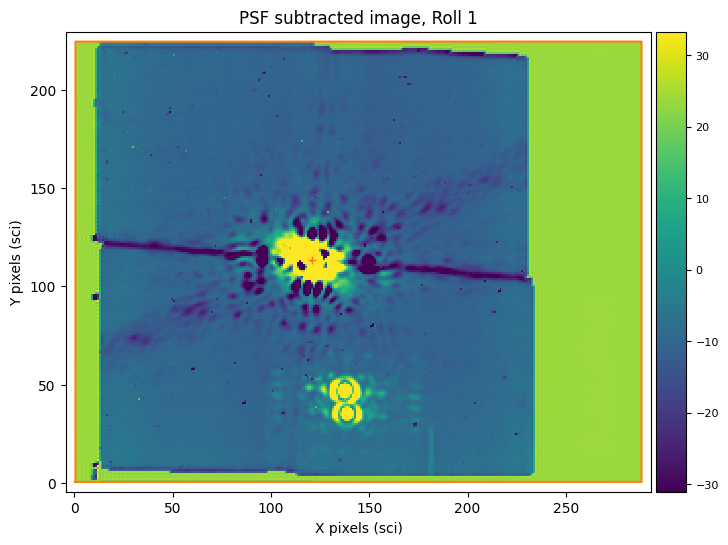

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
fig, ax = plot_with_aper(subtracted_image[0], aper_name=aper_name, ax=ax, plot_kws={'vmin':vmin, 'vmax':vmax})
ax.set_title("PSF subtracted image, Roll 1")

The `klip` step has successfully made a synthetic psf reference image and subtracted it from the target PSF - indeed, the two companion PSFs that were injected into the target PSF are now visable. The output stack of PSF-subtracted images has the same dimensions as the input science target product.

------------------------------------------------------
<a id="resample"></a>
### `resample`: Image resampling

The role of the `resample` step is to combine the PSF-subtracted and CR-flagged images into a single resampled image. The `resample` routine will resample each input 2D image based on the WCS and distortion information, and will combine multiple resampled images into a single undistorted product for the science target.  

*Output*: **2D resampled Images**</br>
*File Suffix*: **_i2d**


> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step


In [16]:
res_hdu = fits.open('jw01386-c1027_t006_miri_f1140c-mask1140_i2d.fits')
res_hdu.info()

Filename: jw01386-c1027_t006_miri_f1140c-mask1140_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     343   ()      
  1  SCI           1 ImageHDU        74   (321, 270)   float32   
  2  ERR           1 ImageHDU        10   (321, 270)   float32   
  3  CON           1 ImageHDU        10   (321, 270, 1)   int32   
  4  WHT           1 ImageHDU         9   (321, 270)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (321, 270)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (321, 270)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (321, 270)   float32   
  8  HDRTAB        1 BinTableHDU    820   2R x 405C   [23A, 5A, 3A, 47A, 7A, 13A, 15A, 5A, 7A, 9A, 4A, L, D, D, D, D, 32A, 51A, 70A, 14A, 3A, D, 28A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 26A, 20A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 10A, 9A, 5A, D, D, D, D, D, D, 27A, D, D, D, 4A, 8A, D, D, 6A, D, D, D, D, D, D, D, 4A, 9A, D, D, D, 

In [17]:
resampled_image = res_hdu[1].data
print("Resampled image dimensions: " + str(resampled_image.shape))

Resampled image dimensions: (270, 321)


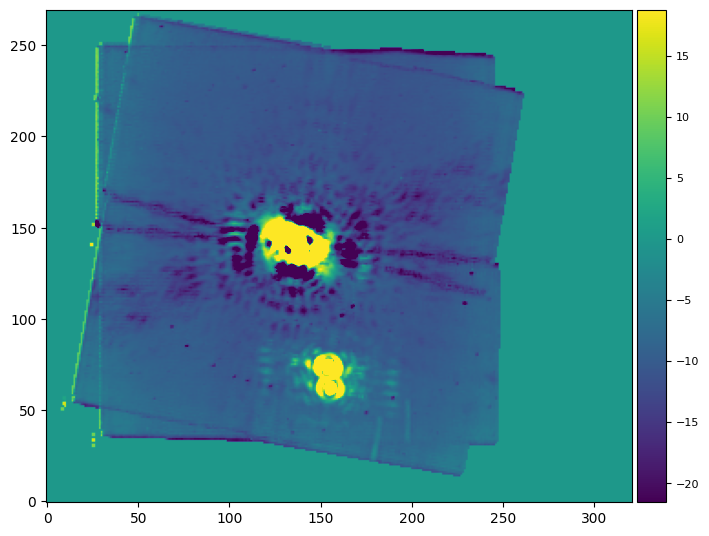

In [25]:
vmin, vmax = np.nanquantile(resampled_image, [0.01, 0.99])
fig, ax = plt.subplots(1, 1, figsize=(8,8))
im = plt.imshow(resampled_image, vmin=vmin, vmax=vmax, origin='lower')
# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=8)

[Top of Page](#title_ID)
<br>
<a id="future_tests"></a>
--------------------

<a id="about"></a>
## About this Notebook
**Authors:** 
- Bryony F. Nickson (Staff Scientist, *MIRI Branch*) 
- J. Brendan Hagan
- Jonathan Aguilar (Staff Scientist, *MIRI Branch*)

<br> **Updated On:** 21/12/2022

[Top of Page](#title_ID)